# Introduction

The aim of this project is to predict whether or not a digital payments transaction is fraudulent or not given data on the bank accounts involved, the time of the transaction and the amount in the transaction. Thus the central question could be phrased as "What information about a digital payments transaction is most helpful when trying to predict whether or not it is fraudulent?"



**Analysis of the dataset**

The (simulated) dataset of 6,362,620 transactions has size 597 MB as per BigQuery. The features included are:

*   "Step" which indicates the hour in which the transaction was simulated (the first transaction in the dataset is at hour 0) 
*   "type" which could be cash-in, cash-out, debit, credit or transfer
*   "amount": the amount of money in the transaction
*   "nameOrig": the "name" (an alphanumeric id) of the original or source account
*   "oldBalanceOrig": the previous balance in the source account
*   "newBalanceOrig": the new balance in the source account
*   "nameDest": the "name" (an alphanumeric id) of the destination account
*   "oldBalanceDest": the previous balance in the destination account
*   "newBalanceDest": the new balance in the destination account
*   "isFlaggedFraud": a boolean indicating whether the amount > 200,000, which we ignore here
*   "isFraud": whether or not the transaction is actually fraudulent

(step, nameOrig, nameDest) acts as a key for this particular dataset, because there are never two transactions from accountA to accountB in the same "step"/hour

In [0]:
# Run this cell to authenticate yourself to BigQuery.
from google.colab import auth
auth.authenticate_user() 
project_id = "adept-bison-219405"

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Exploration and Visualizatiions

In [0]:
# Bar chart of number of transactions of each type

%%bigquery --project $project_id count_by_type

SELECT type, COUNT(type) as num
FROM `adept-bison-219405.fraud_detection.fraud_detection`
GROUP BY type
ORDER BY type

Text(0, 0.5, 'count')

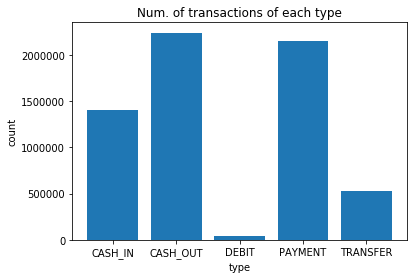

In [0]:
plt.figure()
plt.bar(count_by_type["type"], count_by_type["num"])
plt.title("Num. of transactions of each type")
plt.xlabel("type")
plt.ylabel("count")

The above graph shows the number of each type of transaction. There are few debit transactions compared to the other types of transactions. (This is not for prediction but to get an understanding of the data.)

In [0]:
# Bar chart of the percentage of transactions that are fraudulent for each type

%%bigquery --project $project_id fraud_percent_by_type

SELECT type, IFNULL(fraud_count / all_count * 100, 0) as percent_fraud
FROM
  (SELECT *
  FROM
    (SELECT type as type_fraud, COUNT(type) as fraud_count
    FROM `adept-bison-219405.fraud_detection.fraud_detection`
    WHERE isFraud = 1
    GROUP BY type) fraud_transac
  FULL OUTER JOIN
    (SELECT type, COUNT(type) as all_count
    FROM `adept-bison-219405.fraud_detection.fraud_detection`
    GROUP BY type) all_transac
  ON fraud_transac.type_fraud = all_transac.type)
ORDER BY percent_fraud DESC

Text(0, 0.5, '% fraud')

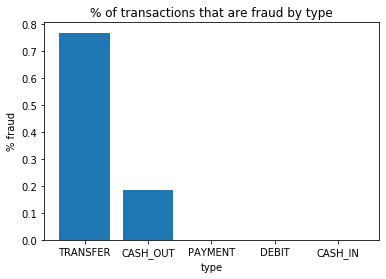

In [0]:
plt.figure()
plt.bar(fraud_percent_by_type["type"], fraud_percent_by_type["percent_fraud"])
plt.title("% of transactions that are fraud by type")
plt.xlabel("type")
plt.ylabel("% fraud")

Question: What proportion of transactions are fraudulent for each transaction type?

The above figure shows that fraud seems to only occur in transfer and cash-out transactions. This makes sense because someone who has stolen a credit/debit card may try to withdraw cash from an ATM or transfer funds to their own bank account. They would not "debit" money away from the actual owner's account or put cash into the actual owner's account. (However, even in tranfer and cash-out transactions, the proportion of transactions that are fraudulent is < 1%.) Transaction type will definitely be used for fraud prediction.

In [0]:
# Average amount in fraud and non-fraud transactions

%%bigquery --project $project_id avg_amount

SELECT isFraud, AVG(amount) as average_amount
FROM `adept-bison-219405.fraud_detection.fraud_detection`
GROUP BY isFraud

Text(0, 0.5, 'average amount')

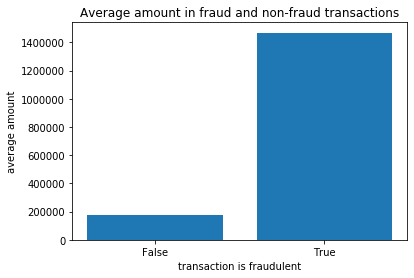

In [0]:
plt.figure()
plt.bar(avg_amount["isFraud"], avg_amount["average_amount"])
plt.title("Average amount in fraud and non-fraud transactions")
plt.xticks([0, 1], ["False", "True"])
plt.xlabel("transaction is fraudulent")
plt.ylabel("average amount")

Question: Is the amount of the transaction correlated with whether or not the transaction is fraudulent?

Fraudulent transactions seem to involve much higher amounts of money on average than legal transactions. This is not surprising because a fraudster is likely to try to extract as much money as they can from the victim's account. Transaction amount will be used for prediction.

In [0]:
# Avg. percent of original account balance involved in the transaction (feature engineering)

%%bigquery --project $project_id pct_of_oldBalanceOrg

SELECT isFraud, AVG(amount / NULLIF(oldBalanceOrg, 0)) as pct_of_oldBalanceOrg
FROM `adept-bison-219405.fraud_detection.fraud_detection`
GROUP BY isFraud

Text(0, 0.5, 'avg percent of original account balance')

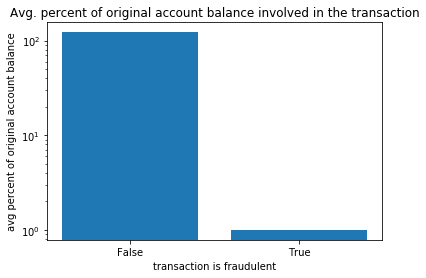

In [0]:
plt.figure()
plt.bar(pct_of_oldBalanceOrg["isFraud"], pct_of_oldBalanceOrg["pct_of_oldBalanceOrg"])
plt.title("Avg. percent of original account balance involved in the transaction")
plt.yscale("log")
plt.xticks([0, 1], ["False", "True"])
plt.xlabel("transaction is fraudulent")
plt.ylabel("avg percent of original account balance")

(Engineered feature)

Question: Is the percentage of the original account balance involved in the transaction correlated with whether or not the transaction is fraudulent?

A hypothesis is that for fraudulent transactions, the percentage of the victim's account balance that will be removed will be close to 100% because the fraudster is trying to obtain as much money as they can. However, this hypothesis is not supported by this data. This quantity is slightly over 100% for legal transactions and slightly below 1% for fraudulent transactions. We are unsure why this is the case. A potential explanation is that there is a number of legal transactions in the dataset that are massive overdrafts, leading to a mean value above 100% for legal transactions. It could also be a data generation issue as the dataset is a synthetic dataset (real financial datasets are hard to come by due to the sensitivity of the data). However, this does not explain why fraudulent transactions on average take out only 1% of the account balance – this could also be the result of an inaccurate data generation process.

In [0]:
# Average new balance of original account

%%bigquery --project $project_id new_balance

SELECT isFraud, AVG(newBalanceOrig) as average_balance_after_trans
FROM `adept-bison-219405.fraud_detection.fraud_detection`
GROUP BY isFraud

Text(0, 0.5, 'average new balance of original account')

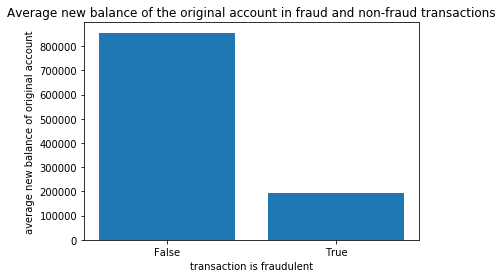

In [0]:
plt.figure()
plt.bar(new_balance["isFraud"], new_balance["average_balance_after_trans"])
plt.title("Average new balance of the original account in fraud and non-fraud transactions")
plt.xticks([0, 1], ["False", "True"])
plt.xlabel("transaction is fraudulent")
plt.ylabel("average new balance of original account")

Question: For fraud and non-fraud transactions, what is the average new balance of the original account (after the transaction has occurred)?

From the chart, we see that fraudulent transactions have a lower average new balance in the original (victim's) account than non-fraudulent transactions. This may be because fraudulent transactions take out more of the money than non-fraudulent transactions, though this would be contradicted by the feature analysis just above this one.

In [0]:
# Destination account balance before the transaction

%%bigquery --project $project_id old_balance

SELECT isFraud, AVG(oldBalanceDest) as average_balance_before_trans
FROM `adept-bison-219405.fraud_detection.fraud_detection`
GROUP BY isFraud

Text(0, 0.5, 'destination balance before transaction')

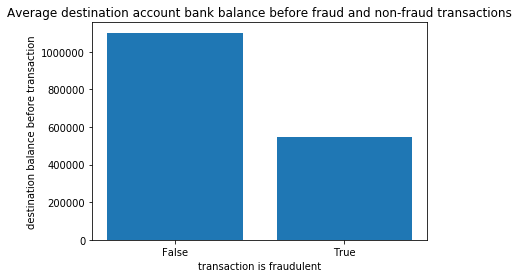

In [0]:
plt.figure()
plt.bar(old_balance["isFraud"], old_balance["average_balance_before_trans"])
plt.title("Average destination account bank balance before fraud and non-fraud transactions")
plt.xticks([0, 1], ["False", "True"])
plt.xlabel("transaction is fraudulent")
plt.ylabel("destination balance before transaction")

Question: How do the bank balances of fraudsters (before a transaction) compare with those of regular customers?

The chart shows that fraudsters' accounts have a lower average balance before a transaction in the dataset as compared to regular customers' accounts. This could be because fraudsters do not store much money in the account they use for defrauding people, and transfer their gains to other accounts.

In [0]:
# Number of transactions in each hour of the day

%%bigquery --project $project_id num_by_hour

SELECT MOD(step, 24) as hour, COUNT(step) as num
FROM `adept-bison-219405.fraud_detection.fraud_detection`
GROUP BY hour
ORDER BY hour

Text(0, 0.5, 'number of transactions')

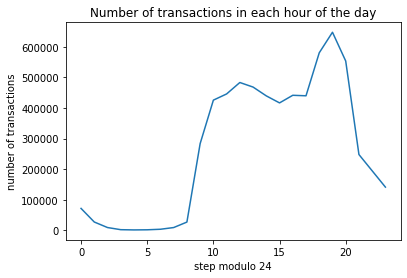

In [0]:
plt.figure()
plt.plot(num_by_hour["hour"], num_by_hour["num"])
plt.title("Number of transactions in each hour of the day")
plt.xlabel("step modulo 24")
plt.ylabel("number of transactions")

(Engineered feature)

(This visualization is to get an understanding of the data – not for prediction.)

Question: How many transactions in the dataset occur in each hour of the day?

The "step" feature in the dataset is the "hour" of the transaction, where the first transaction in the dataset occured during hour 0. We plotted the number of transactions for each value of ("step" mod 24) because we do not know which hour of the day corresponds to hour 0. It seems as though many transactions occur between stepMod24=9 and stepMod24=20. This seems to suggest that hour 0 may correspond to around midnight, because 9am-8pm intuitively makes sense for high transaction frequency. There are also peaks at stepMod24=12 and stepMod24=19, which could correspond to lunchtime and dinner time.

In [0]:
# Proportion of transactions that are fraud in each hour of the day

%%bigquery --project $project_id pct_fraud_by_hour

SELECT hour1, num_fraud / num * 100 as pct_fraud
FROM
  (SELECT MOD(step, 24) as hour1, COUNT(step) as num
  FROM `adept-bison-219405.fraud_detection.fraud_detection`
  GROUP BY hour1
  ORDER BY hour1) total
JOIN
  (SELECT MOD(step, 24) as hour2, COUNT(step) as num_fraud
  FROM `adept-bison-219405.fraud_detection.fraud_detection`
  WHERE isFraud = 1
  GROUP BY hour2
  ORDER BY hour2) fraud
ON total.hour1 = fraud.hour2
ORDER BY hour1

Text(0, 0.5, '% of transactions that are fraud')

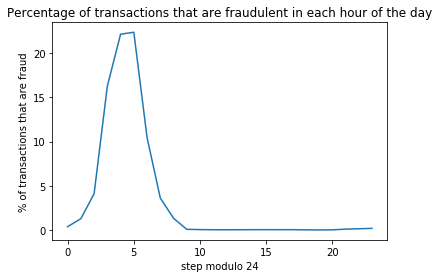

In [0]:
plt.figure()
plt.plot(pct_fraud_by_hour["hour1"], pct_fraud_by_hour["pct_fraud"])
plt.title("Percentage of transactions that are fraudulent in each hour of the day")
plt.xlabel("step modulo 24")
plt.ylabel("% of transactions that are fraud")

(Engineered feature)

Question: Is the proportion of transactions that are fraudulent correlated with the hour of day when the transaction occurs?

The plot above suggests that a transaction occuring between 3am and 5am is much more likely to be fraudulent than one occuring at another time. This intuitively makes sense because a fraudster may try to carry out fraud when the victim is likely to be asleep and to not read or respond to, for instance, text notifications. This feature will be used for prediction.

All of the features considered showed a significant correlation with whether or not the transaction is fraudulent. Particularly prominent were: transaction type, amount, % of the original account balance involved, and hour of day. The questions we had about the dataset were in general answered by the visualizations.

One surprising result discussed above is the average percentage of the original account balance involved in the transaction. Non-fraudulent transactions appeared to involve >100% of the balance on average, which is unrealistic and suggests an issue with the (simulated) dataset. As mentioned above, this could be casued by a few transactions being massive overdrafts, and further exploration is needed. 

# Predicting fraudulent transactions

In [0]:
%%bigquery --project $project_id data_for_ML

SELECT type, amount, amount / NULLIF(oldBalanceOrg, 0) as pctOfOrigBalance, newBalanceOrig, oldBalanceDest, MOD(step, 24) as hour, isFraud
FROM `adept-bison-219405.fraud_detection.fraud_detection`
WHERE RAND() < 0.05


In [0]:
from sklearn.utils import shuffle
df = shuffle(data_for_ML).dropna()
print(df["isFraud"].value_counts()) # 1:533 = fraud:non-fraud

0    212600
1       399
Name: isFraud, dtype: int64


In [0]:
from sklearn.utils import resample
df_majority = df[df.isFraud==0]
df_minority = df[df.isFraud==1]
 
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=212600,
                                 random_state=1)
 
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
df_upsampled.isFraud.value_counts()

1    212600
0    212600
Name: isFraud, dtype: int64

In [0]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df_upsampled = shuffle(df_upsampled)
y = df_upsampled["isFraud"]
X = df_upsampled.drop("isFraud", axis=1)
le = LabelEncoder() 
X['type']= le.fit_transform(X['type'])
onehotencoder = OneHotEncoder(categorical_features = [0])
X = onehotencoder.fit_transform(X).toarray()
X.shape, y.shape

In [0]:
X_train, X_test = X[:400000], X[400000:]
y_train, y_test = y[:400000], y[400000:]

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
y_pred = LogisticRegression().fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.92      0.59      0.72     12584
           1       0.70      0.95      0.81     12616

    accuracy                           0.77     25200
   macro avg       0.81      0.77      0.76     25200
weighted avg       0.81      0.77      0.76     25200



Above, we show that it is possible to predict with 77% accuracy whether a transaction is fraudulent or not on a balanced test set. We sampled a balanced dataset of 425000 transactions, of which 400000 were used for training and 25000 were used for testing. Both training and testing were done on roughly balanced datasets (the minority class of fraudulent transactions was upsampled to make this possible). All features that were mentioned in the visualization section were used.

Accuracy here is the percentage of transactions in the test set that were labelled correctly as fraudulent or non-fraudulent.

# Conclusion



In this project, we explored different features for predicting whether a transaction is fraudulent or not. Transaction type, amount, % of the original account balance involved and time of day were found to be highly correlated with whether the transaction was fraudulent or not, and so were the new balance of the original account, and the former balance of the destination account.

These features were used to train a logistic regression model which could predict whether a transaction is an unseen balanced test set was fraudulent with 77% accuracy. 77% is significantly above 50%, which would be the accuracy expected for randomly guessing whether or not a transaction is fraudulent. This suggests that the features explored do have significant predictive power. However, there is definitely potential for further increasing predictive accuracy. Data on the geographical location of the transaction may help and further research could explore how adding geographical data affects predictive performance. It would also be interesting to explore how the history (past transactions) of a bank account could be used to predict fraudulent transactions.